In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns 

import os

import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

In [2]:
path_db =  {}

for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        path = os.path.join(dirname, filename)
        path_db[filename.replace('.csv','')] = path
        
path = path_db['WA_Fn-UseC_-Telco-Customer-Churn']
df = pd.read_csv(path)

print(f'Data path: {path} - {df.shape}')

df.head()

Data path: /kaggle/input/telco-customer-churn/WA_Fn-UseC_-Telco-Customer-Churn.csv - (7043, 21)


,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [3]:
df['SeniorCitizen']

0       0
1       0
2       0
3       0
4       0
       ..
7038    0
7039    0
7040    0
7041    1
7042    0
Name: SeniorCitizen, Length: 7043, dtype: int64

In [4]:
# Utiliy Functions for Visualization
def boxplot_wannotation_plot(df: pd.DataFrame) -> None:
    num_columns = len(df.columns)
    num_rows = (num_columns // 3) + (num_columns % 3)

    fig, axes = plt.subplots(nrows=num_rows, ncols=3, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, col in enumerate(df.columns):
        ax = axes[i]
        boxplot = df[col].plot(kind='box', ax=ax, sharex=False, sharey=False,
                            meanline=True, showmeans =True, meanprops={'color': 'red', 'linestyle': '--'})
        ax.set_title(f'{col}')
        ax.set_xticks([])

        # Calculate the median and mean
        median, mean = df[col].median(), df[col].mean()

        # Mean and Median Annotation
        ax.text(0.62, 0.9, f'Median: {median:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='green')
        ax.text(0.62, 0.8, f'Mean: {mean:.2f}', transform=ax.transAxes,
                fontsize=9, verticalalignment='top',color='red')

        # Outlier calculation and Annotation
        q1 = df[col].quantile(0.25)
        q3 = df[col].quantile(0.75)
        iqr = q3 - q1
        lower_bound = q1 - 1.5 * iqr
        upper_bound = q3 + 1.5 * iqr
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)][col]
        ax.text(0.62, 0.7, f'Outliers: {len(outliers)}', transform=ax.transAxes, fontsize=9, verticalalignment='top')

    for i in range(num_columns, len(axes)):
        fig.delaxes(axes[i])

    plt.tight_layout()
    plt.show()
    

def distribution_wannotation_plot(df: pd.DataFrame) -> None:
    num_features = len(df.columns) - 1
    num_rows,num_cols = 1, 3
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 8 * num_rows // 2))
    axes = axes.flatten()

    for i, column in enumerate(df.columns):
        ax = axes[i]
        # Plot All the data points
        sns.histplot(data=df, x=column, bins=20, common_norm=False, ax=ax,
                    legend=False, color='orange', alpha=0.2, edgecolor='none')

        # Plot the data points seperated by hue (Outcome)
        sns.histplot(data=df, x=column, bins=20, common_norm=False, kde=True,
                    ax=ax, legend=False, palette={0: 'blue', 1: 'red'}, alpha=0.4, edgecolor='none')

        mean = df[column].mean()
        var = df[column].var()
        skew = df[column].skew()

        ax.set_title(f'{column}\n(Mean={mean:.2f}, Var={var:.2f}, Skew={skew:.2f})')
        ax.set_xlabel(column)
        ax.set_ylabel('Frequency')

    plt.tight_layout()
    plt.show()

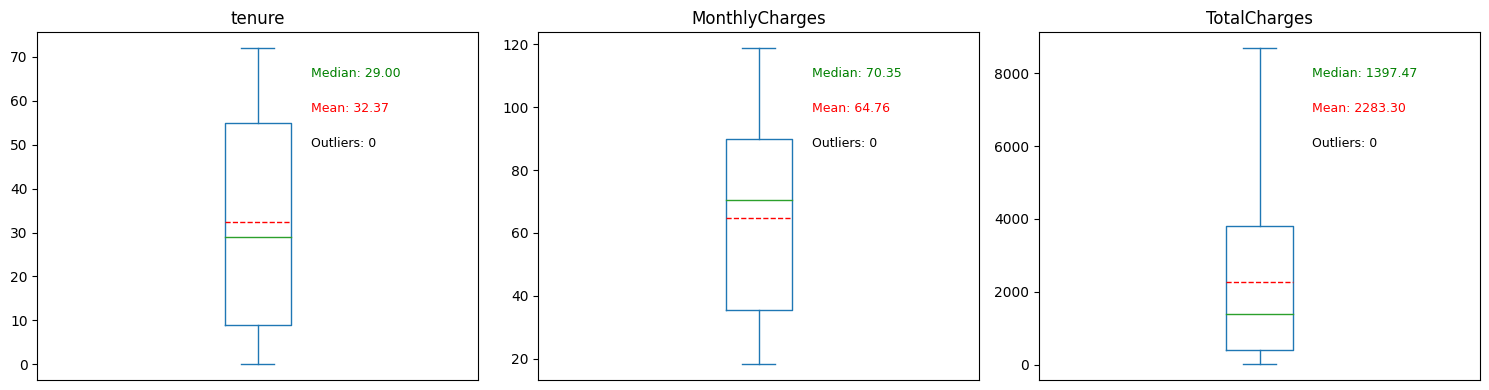

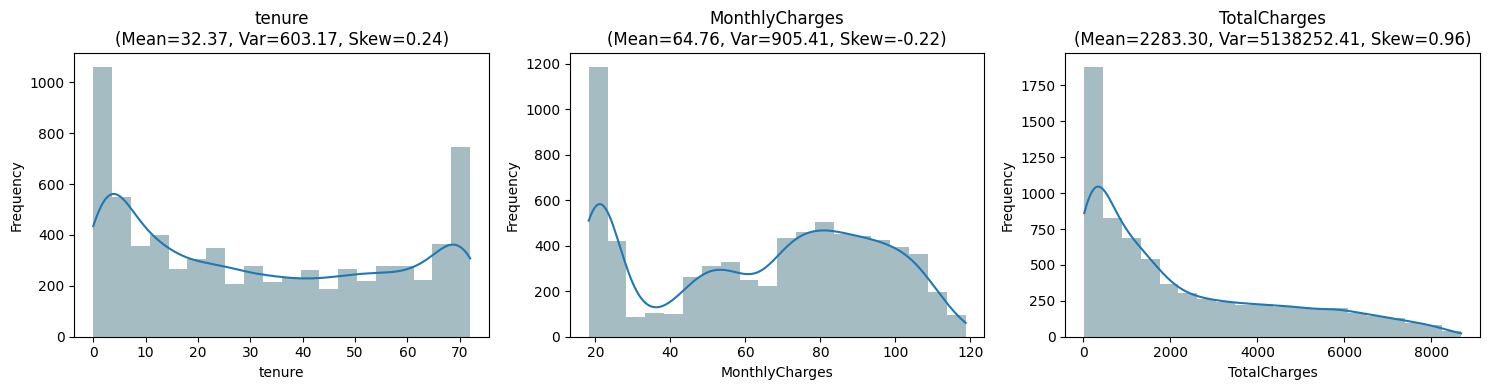

In [5]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
numerical_data_col = ['tenure','MonthlyCharges','TotalCharges']
boxplot_wannotation_plot(df[numerical_data_col])
distribution_wannotation_plot(df[numerical_data_col])

There is no outliers among the numerical data in the dataset; hence, we don't have to remove any outliers.

### Features Exploration and Engineering

Services that each customer has signed up for – phone, multiple lines, internet, online security, online backup, device protection, tech support, and streaming TV and movies. Columns that are associated with this features include: **'PhoneService', 'InternetService', 'OnlineSecurity',
       'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV',
       'StreamingMovies'**

In [6]:
sdf = df.iloc[:,1:]
telco_products = [
    'PhoneService', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 
    'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies'
]

# All Services 
sdf['AllServiceProportion'] = (
    sdf['PhoneService'].map({'Yes': 1, 'No': 0}) + 
    sdf['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0}) + 
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +  
    sdf['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 8

# Online Activity Services
sdf['OnlineProportion'] = (
    sdf['InternetService'].map({'DSL': 1, 'Fiber optic': 1, 'No': 0}) + 
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +   
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 5

# Protection Services 
sdf['ProtectionProportion'] = (
    sdf['OnlineSecurity'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['OnlineBackup'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['DeviceProtection'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) + 
    sdf['TechSupport'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 4

# Streaming Services
sdf['StreamingProportion'] = (
    sdf['StreamingTV'].map({'Yes': 1, 'No': 0, 'No internet service': 0}) +
    sdf['StreamingMovies'].map({'Yes': 1, 'No': 0, 'No internet service': 0})
) / 2

df = sdf.copy()

sdf.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,...,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,AllServiceProportion,OnlineProportion,ProtectionProportion,StreamingProportion
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,...,Month-to-month,Yes,Electronic check,29.85,29.85,No,0.25,0.4,0.25,0.0
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,...,One year,No,Mailed check,56.95,1889.50,No,0.50,0.4,0.50,0.0
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,...,Month-to-month,Yes,Mailed check,53.85,108.15,Yes,0.50,0.6,0.50,0.0
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,...,One year,No,Bank transfer (automatic),42.30,1840.75,No,0.50,0.4,0.75,0.0
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,...,Month-to-month,Yes,Electronic check,70.70,151.65,Yes,0.25,0.2,0.00,0.0


### Preprocess Numerical Data

In [7]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# Imputation (incase for missing values) based on the visualization
df['tenure'] = df['tenure'].fillna(df['tenure'].mean()) 
df['MonthlyCharges'] = df['MonthlyCharges'].fillna(df['MonthlyCharges'].mean()) 
df['TotalCharges'] = df['TotalCharges'].fillna(df['TotalCharges'].median()) 

# Need to perform Z-score Normalization on the numerical data
# Using Z-score Normalization because we DON'T know the possible Range 
znorm_scaler = StandardScaler()

# Using MinMaxScaler to make the data numerical dat within the same range as categorical of [0,1]??
minmax_scaler = MinMaxScaler(feature_range = (0,1))

numerical_data_col = ['tenure','MonthlyCharges','TotalCharges','AllServiceProportion','OnlineProportion','ProtectionProportion','StreamingProportion']
numerical_df = df[numerical_data_col]

transnumerical_data_col = [f'{col}_norm' for col in numerical_data_col]
numerical_df[transnumerical_data_col] = znorm_scaler.fit_transform(numerical_df[numerical_data_col])
# numerical_df[transnumerical_data_col] = minmax_scaler.fit_transform(numerical_df[numerical_data_col])

numerical_df.head()

,tenure,MonthlyCharges,TotalCharges,AllServiceProportion,OnlineProportion,ProtectionProportion,StreamingProportion,tenure_norm,MonthlyCharges_norm,TotalCharges_norm,AllServiceProportion_norm,OnlineProportion_norm,ProtectionProportion_norm,StreamingProportion_norm
0,1,29.85,29.85,0.25,0.4,0.25,0.0,-1.277445,-1.160323,-0.994242,-0.821114,-0.118952,-0.206447,-0.905859
1,34,56.95,1889.50,0.50,0.4,0.50,0.0,0.066327,-0.259629,-0.173244,0.131229,-0.118952,0.570682,-0.905859
2,2,53.85,108.15,0.50,0.6,0.50,0.0,-1.236724,-0.362660,-0.959674,0.131229,0.516691,0.570682,-0.905859
3,45,42.30,1840.75,0.50,0.4,0.75,0.0,0.514251,-0.746535,-0.194766,0.131229,-0.118952,1.347810,-0.905859
4,2,70.70,151.65,0.25,0.2,0.00,0.0,-1.236724,0.197365,-0.940470,-0.821114,-0.754595,-0.983576,-0.905859


### Preprocess Categorical Data

In [8]:
from sklearn.preprocessing import LabelEncoder

# Encoding the Categorical Data - including the Churn (Prediction Class)
categorical_df = df.drop(columns = numerical_data_col, axis = 1).iloc[:,1:]
original_categorical_columns = categorical_df.columns.tolist()

label_encoders = {}
label_to_original = {}

# Apply LabelEncoder to each feature and store the direct conversion in a dictionary
for column in categorical_df.select_dtypes(include=['object','int']).columns:
    le = LabelEncoder()
    categorical_df[column + '_Encoded'] = le.fit_transform(categorical_df[column])
    label_encoders[column] = le
    label_to_original[column] = dict(zip(le.transform(categorical_df[column]), categorical_df[column]))

encoded_columns = [col for col in categorical_df.columns if col.endswith('Encoded')]

categorical_df[encoded_columns].head()

,SeniorCitizen_Encoded,Partner_Encoded,Dependents_Encoded,PhoneService_Encoded,MultipleLines_Encoded,InternetService_Encoded,OnlineSecurity_Encoded,OnlineBackup_Encoded,DeviceProtection_Encoded,TechSupport_Encoded,StreamingTV_Encoded,StreamingMovies_Encoded,Contract_Encoded,PaperlessBilling_Encoded,PaymentMethod_Encoded,Churn_Encoded
0,0,1,0,0,1,0,0,2,0,0,0,0,0,1,2,0
1,0,0,0,1,0,0,2,0,2,0,0,0,1,0,3,0
2,0,0,0,1,0,0,2,2,0,0,0,0,0,1,3,1
3,0,0,0,0,1,0,2,0,2,2,0,0,1,0,0,0
4,0,0,0,1,0,1,0,0,0,0,0,0,0,1,2,1


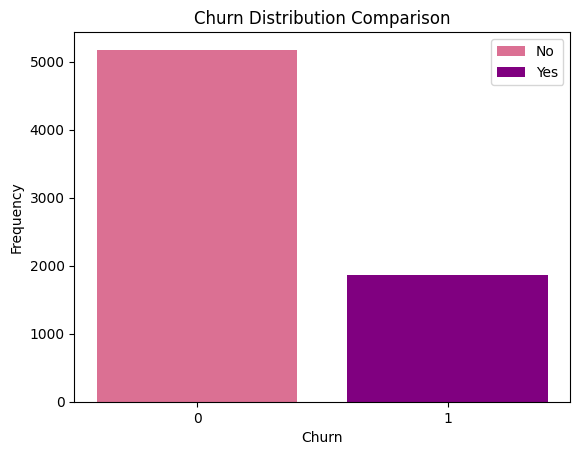

In [9]:
class_labels = label_to_original['Churn']
categorical_df['Churn_Label'] = categorical_df['Churn_Encoded'].map(class_labels)
value_counts = categorical_df['Churn_Encoded'].value_counts()

unique_values = value_counts.index
plt.bar(unique_values, value_counts, color=['palevioletred','purple'], tick_label=unique_values, label=class_labels.values())

plt.xlabel('Churn')
plt.ylabel('Frequency')
plt.title('Churn Distribution Comparison')
plt.legend()
plt.show()

We can clearly see the class imbalance between Churn and Not Churn. Therefore, we have to manipulation methods to increase the number of data

Original Data:
Churn: (1869, 23)
Not Churn: (5174, 23)

Upsample Data:
Churn: (5174, 23)
Not Churn: (5174, 23)

Final Data: (10348, 23)


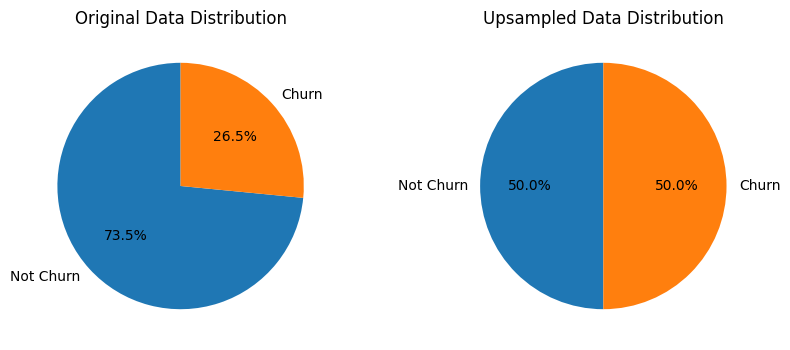

In [10]:
from sklearn.utils import resample

X = pd.concat([categorical_df[encoded_columns], numerical_df[transnumerical_data_col]], axis = 1) # Still contain the prediction class

X_Churn, X_NChurn = X[X['Churn_Encoded'] == 1], X[X['Churn_Encoded'] == 0]
print(f'Original Data:\nChurn: {X_Churn.shape}\nNot Churn: {X_NChurn.shape}\n')

X_Churn_upsample = resample(
    X_Churn,
    replace=True,
    n_samples=len(X_NChurn),
    random_state=0
)
print(f'Upsample Data:\nChurn: {X_Churn_upsample.shape}\nNot Churn: {X_NChurn.shape}\n')

X_upsample = pd.concat([X_NChurn, X_Churn_upsample], axis=0)
print(f'Final Data: {X_upsample.shape}')

# Plot visualization for Original and Upsampled Data
fig, axes = plt.subplots(1, 2, figsize=(10, 4))

original_distribution = X.groupby('Churn_Encoded').size()
axes[0].pie(original_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[0].set_title('Original Data Distribution')

upsampled_distribution = X_upsample.groupby('Churn_Encoded').size()
axes[1].pie(upsampled_distribution, labels=['Not Churn', 'Churn'], autopct='%1.1f%%', startangle=90)
axes[1].set_title('Upsampled Data Distribution')

plt.show()

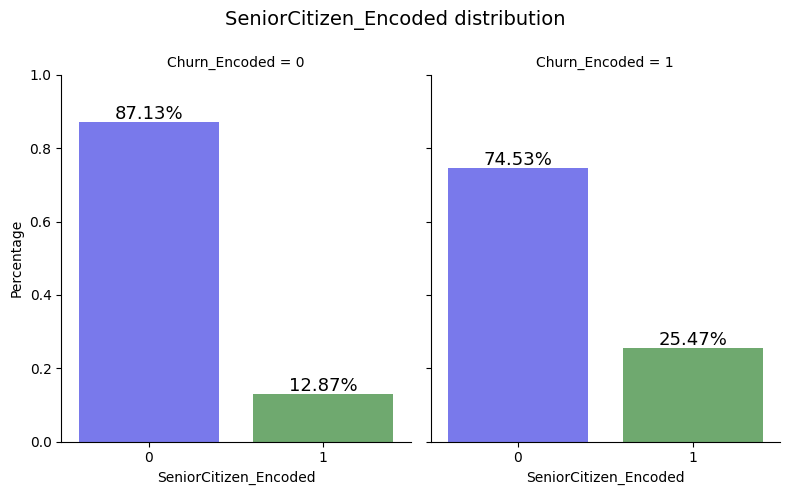

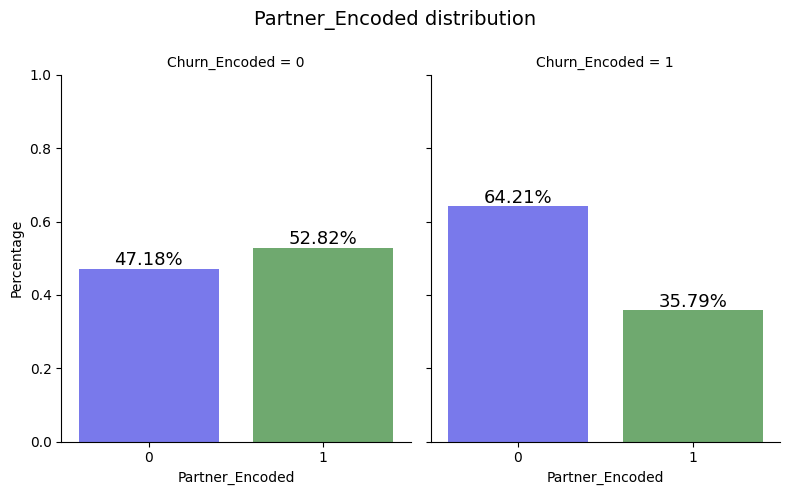

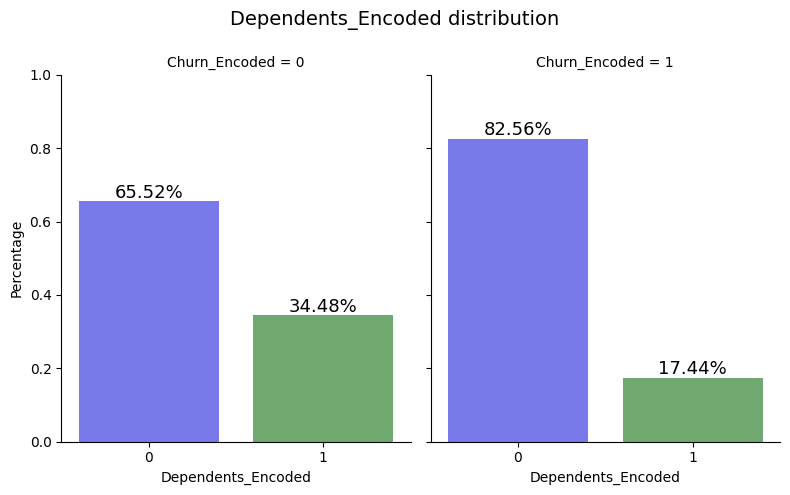

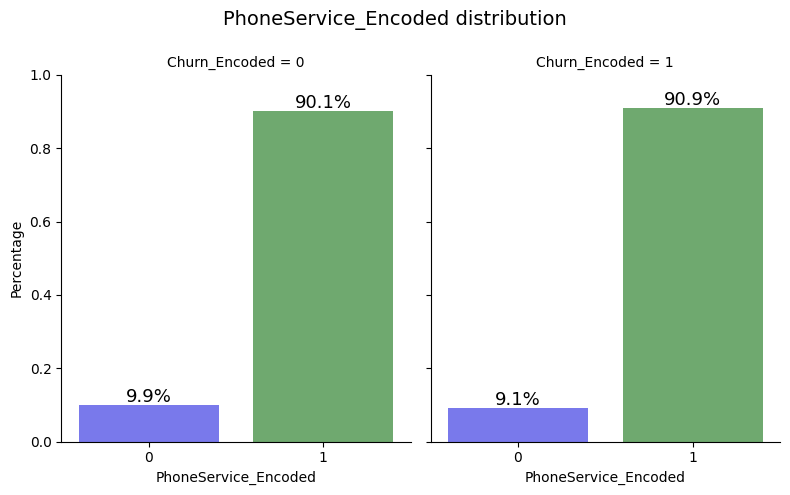

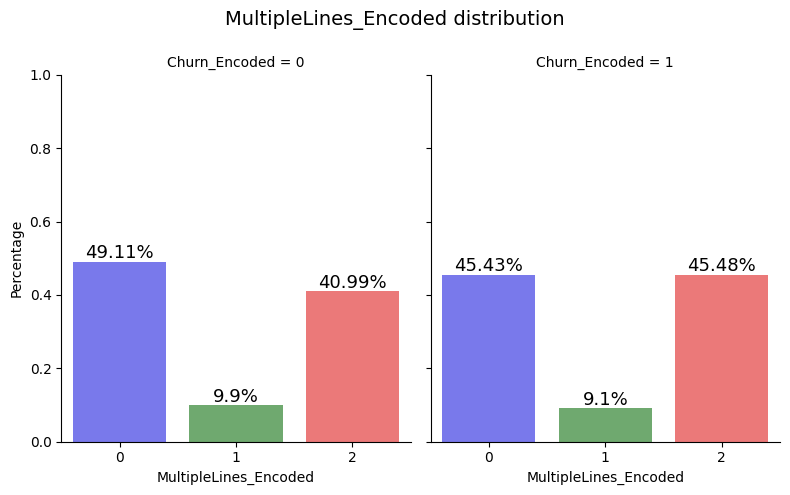

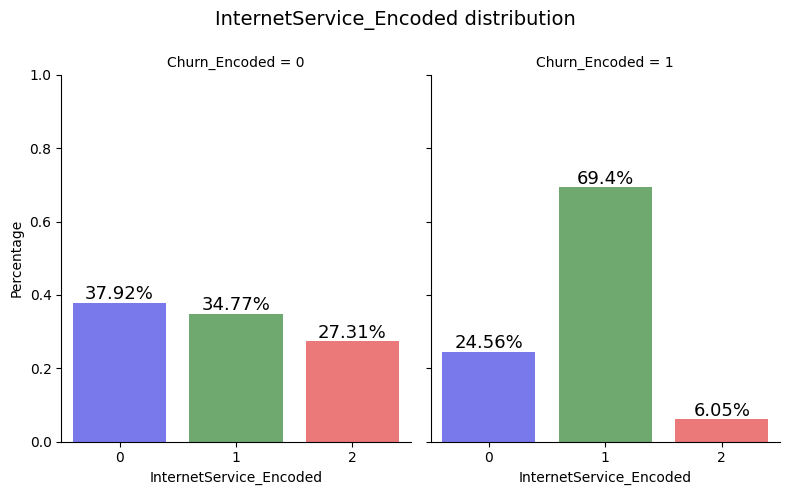

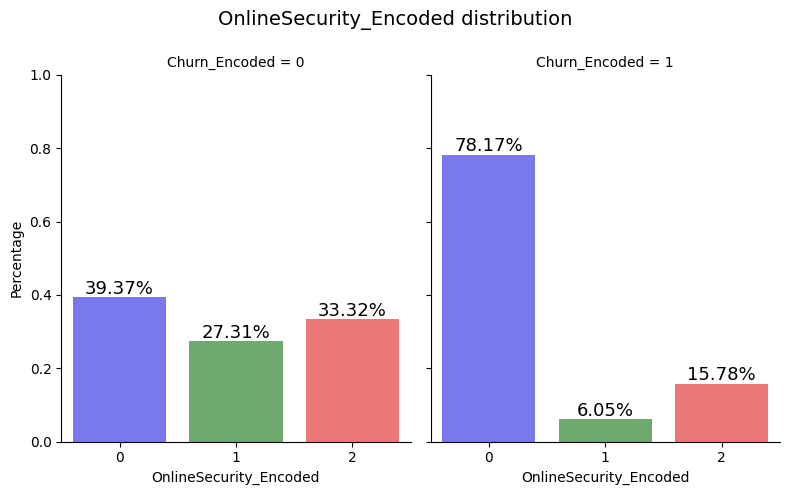

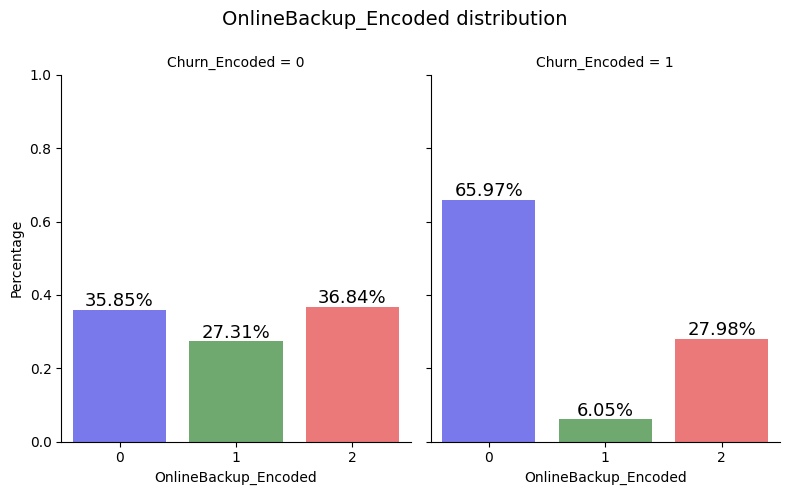

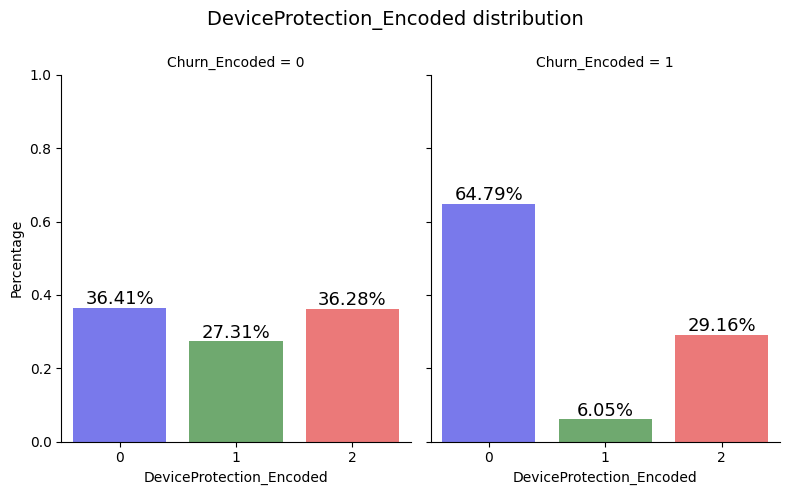

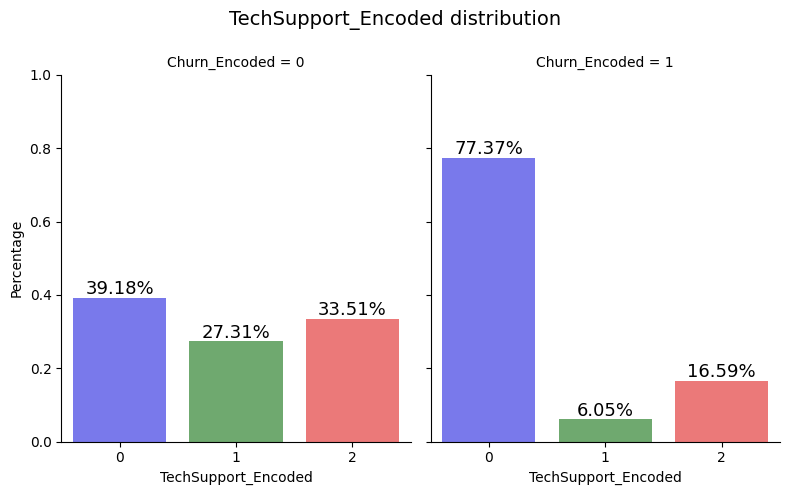

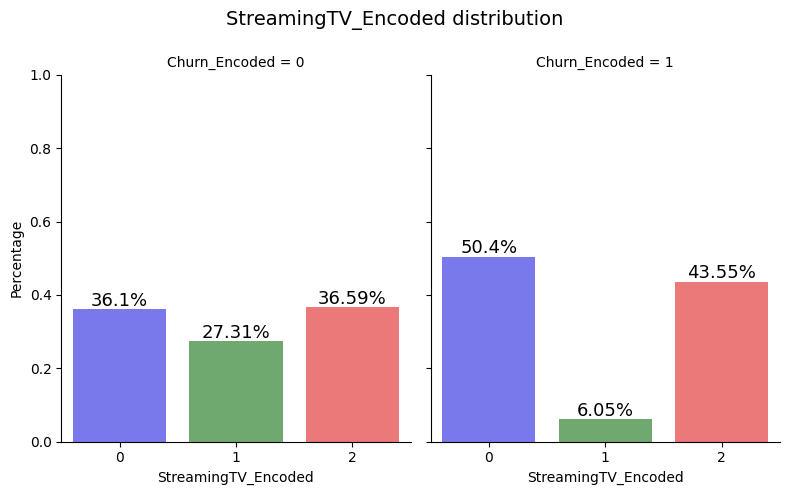

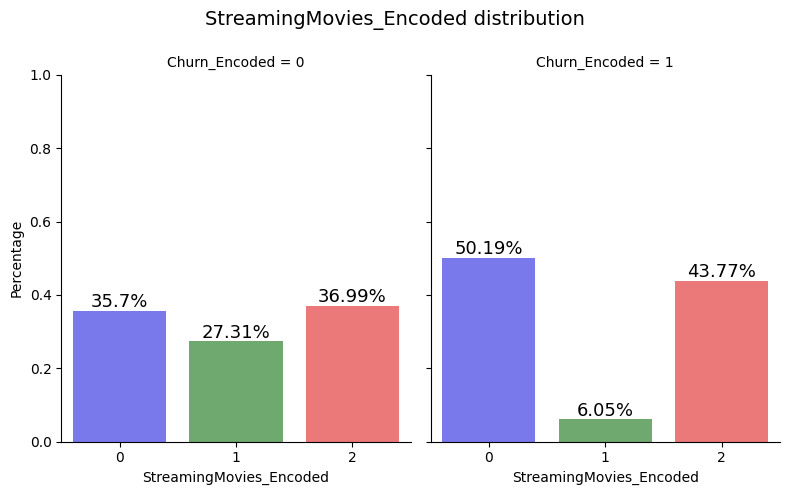

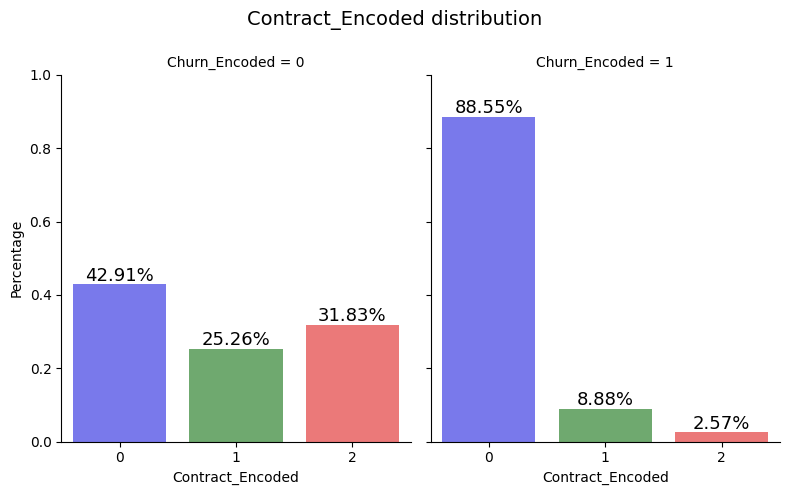

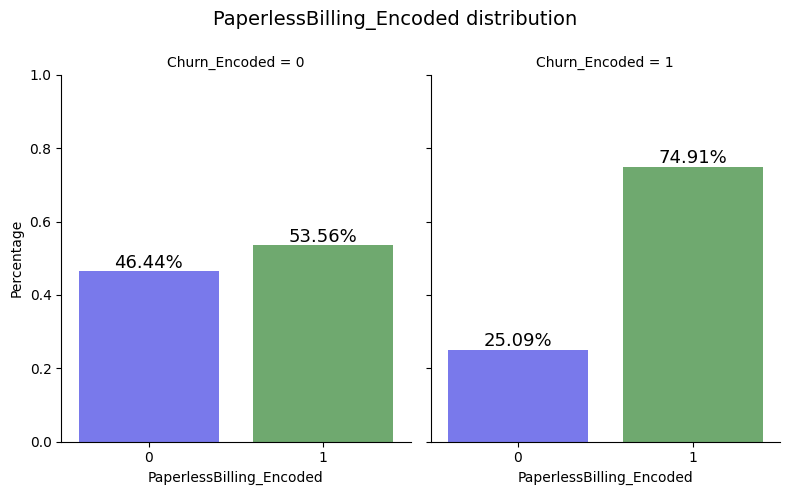

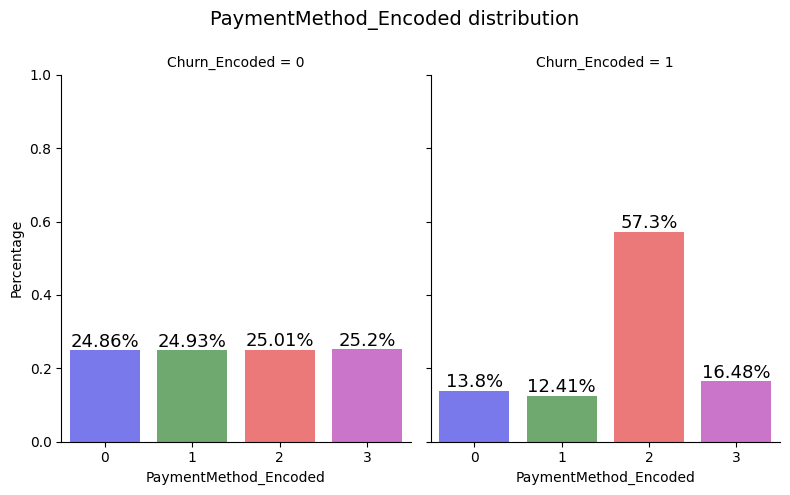

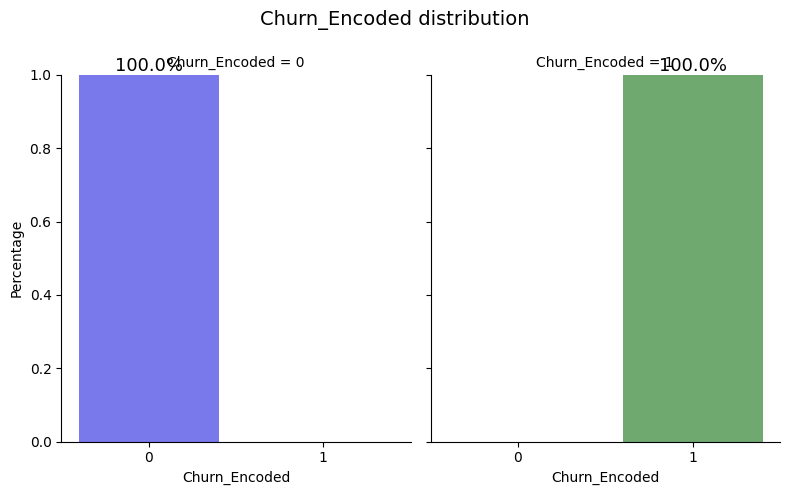

In [11]:
def create_data_label(ax):
    """ Display data label for given axis """
    for bar in ax.patches:
            ax.text(bar.get_x() + bar.get_width()/ 2
                    , bar.get_height() + 0.01
                    , str(round(100 * bar.get_height(),2)) + '%'
                    , ha = 'center'
                    , fontsize = 13)
            
            
def categorical_var_churn_dist(data, cols, distribution_col):
    """ Distribution of categorical variable based on target variable """
    
    for i,feature in enumerate(cols):
        
        feature_summary = data[feature].value_counts(normalize=True).reset_index(name='Percentage')
        
        plt_cat = sns.catplot(x=feature
                , y='Percentage'
                , data = feature_summary
                , col=distribution_col
                , kind='bar'
                , aspect = 0.8
                , palette = plotColor
                , alpha = 0.6)
        
        if feature == 'PaymentMethod':
            plt_cat.set_xticklabels(rotation= 65, horizontalalignment = 'right')
        
        
        for ax1, ax2 in plt_cat.axes:
            create_data_label(ax1)
            create_data_label(ax2)
        
        plt.ylim(top=1)
        plt.subplots_adjust(top = 0.85)
        plt.gcf().suptitle(feature+" distribution",fontsize=14)
    plt.show()

plotColor = ['b','g','r','m','c', 'y']
churn_summary = X.groupby('Churn_Encoded')
categorical_var_churn_dist(churn_summary, encoded_columns,'Churn_Encoded')

# Model Development

1. Prepare training and testing data
2. Model Selection: select three based classification models
3. Model Construction: implement new classification model architecture
4. Train the models
5 .

In [12]:
from sklearn.model_selection import train_test_split

X_upsample_temp = X_upsample.drop('Churn_Encoded', axis=1)
X_final = X_upsample_temp.values
y_final = X_upsample['Churn_Encoded'].values

X_train, X_test, y_train, y_test = train_test_split(X_final, y_final, test_size=0.3, random_state=0)
print(f'Training Data: {X_train.shape}, {y_train.shape}\nTesting Data: {X_test.shape}, {y_test.shape}')

Training Data: (7243, 22), (7243,)
Testing Data: (3105, 22), (3105,)


0.7642512077294686
Axes(0.125,0.11;0.775x0.77)


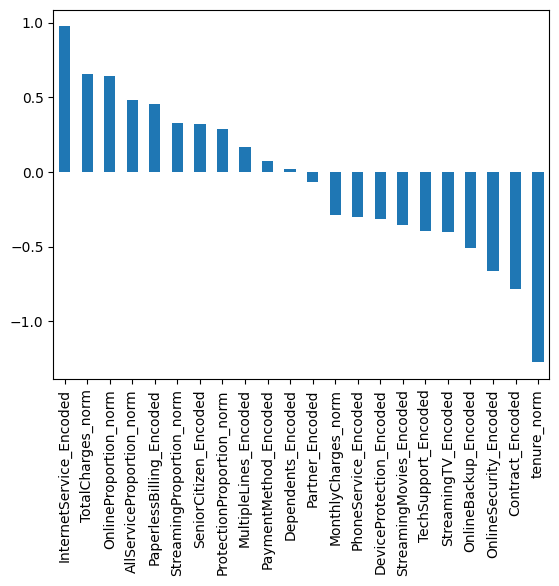

In [13]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix  

lr = LogisticRegression()
result = lr.fit(X_train, y_train)

prediction_test = lr.predict(X_test)
print(accuracy_score(y_test, prediction_test))

weights = pd.Series(lr.coef_[0], index=X_upsample_temp.columns.values)
print(weights.sort_values(ascending = False).plot(kind='bar'))
plt.show()

In [14]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import cross_val_score

dtc = DecisionTreeClassifier()
dtc.fit(X_train, y_train)

y_pred_dtc = dtc.predict(X_test)

acc_dtc = accuracy_score(y_test, y_pred_dtc)
conf = confusion_matrix(y_test, y_pred_dtc)
clf_report = classification_report(y_test, y_pred_dtc)

print(f"Accuracy Score of Decision Tree is : {acc_dtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

cross_val_scores = cross_val_score(dtc, X_train, y_train, cv=5, scoring='accuracy')

mean_cv_accuracy = cross_val_scores.mean()
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean Cross-Validation Accuracy: {mean_cv_accuracy:.2f}")

Accuracy Score of Decision Tree is : 0.8582930756843801
Confusion Matrix : 
[[1204  332]
 [ 108 1461]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.78      0.85      1536
           1       0.81      0.93      0.87      1569

    accuracy                           0.86      3105
   macro avg       0.87      0.86      0.86      3105
weighted avg       0.87      0.86      0.86      3105

Cross-Validation Accuracy Scores: [0.83436853 0.85714286 0.84057971 0.84185083 0.83632597]
Mean Cross-Validation Accuracy: 0.84


0.7713365539452496


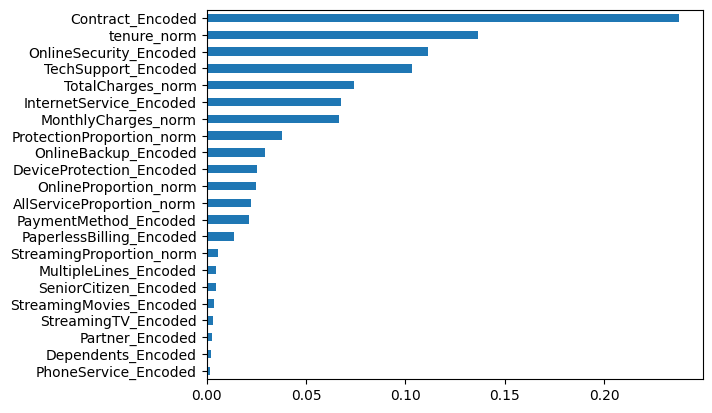

In [15]:
from sklearn.ensemble import RandomForestClassifier

rd_clf = RandomForestClassifier(
    n_estimators=1000 , 
    oob_score = True,
    n_jobs = -1,
    random_state = 0, 
    max_features = "auto",
    max_leaf_nodes = 30
)

rd_clf.fit(X_train, y_train)
prediction_test = rd_clf.predict(X_test)
print(accuracy_score(y_test, prediction_test))

importances = rd_clf.feature_importances_
weights = pd.Series(importances, index=X_upsample_temp.columns.values)
weights.sort_values().plot(kind = 'barh')
plt.show()

In [16]:
# from sklearn.model_selection import KFold, StratifiedKFold
# from sklearn.neural_network import MLPClassifier
# from sklearn.ensemble import StackingClassifier

# x_train_new_SVMSmote = X_train
# y_train_SVMSmote = y_train

# CV = StratifiedKFold(n_splits=10, random_state=0, shuffle=True)

# estimators = [('DT', DT),
#               ('RF', RF),
#               ('MLP', MLP),
#               ('ET', ET),
#               ('LR', LR),
#               ('KNN', KNN),
#               ('GB', GB),
#               ('LGBM', LGBM)
#              ]

# DT = DecisionTreeClassifier(criterion='entropy', min_samples_leaf=5, random_state=0)
# cross_val_DT = cross_val_score(DT, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_DT_f1 = cross_val_score(DT, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# RF = RandomForestClassifier(min_samples_leaf=2, min_samples_split=4, n_estimators=50, random_state=0)
# cross_val_RF = cross_val_score(RF, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_RF_f1 = cross_val_score(RF, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# ET = ExtraTreesClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=4, random_state=0)
# cross_val_ET = cross_val_score(ET, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_ET_f1 = cross_val_score(ET, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# MLP = MLPClassifier(activation='logistic', hidden_layer_sizes=10, learning_rate_init=0.2, max_iter=50, random_state=0)
# cross_val_MLP = cross_val_score(MLP, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_MLP_f1 = cross_val_score(MLP, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# GB = GradientBoostingClassifier(loss='exponential', max_depth=4, min_samples_leaf=4, random_state=0)
# cross_val_GB = cross_val_score(GB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_GB_f1 = cross_val_score(GB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# LR = LogisticRegression(C=6, penalty='none', random_state=0)
# cross_val_LR = cross_val_score(LR, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_LR_f1 = cross_val_score(LR, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# XGB = XGBClassifier(learning_rate_init= 0.025, max_depth= 6, n_estimators= 300, n_jobs=-1, random_state = 0,
#                     min_child_weight= 1, colsample_bytree= 0.6, gamma= 0.5)
# cross_val_XGB = cross_val_score(XGB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_XGB_f1 = cross_val_score(XGB, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# KNN = KNeighborsClassifier(n_neighbors=13)
# cross_val_KNN = cross_val_score(KNN, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_KNN_f1 = cross_val_score(KNN, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# LGBM = LGBMClassifier(boosting_type='dart', learning_rate=0.2, max_depth=6, min_child_samples=10, 
#                       n_estimators=200, num_leaves=40, random_state=0, reg_alpha=0.01)
# cross_val_LGBM = cross_val_score(LGBM, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'accuracy') 
# cross_val_LGBM_f1 = cross_val_score(LGBM, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, scoring = 'f1') 

# # --------------------------------------------------------------------------
# SC_tune = StackingClassifier(estimators = estimators, final_estimator = MLP)
# cross_val_SC_tune = cross_val_score(SC_tune, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, 
#                                     scoring = 'accuracy') 
# cross_val_SC_tune_f1 = cross_val_score(SC_tune, x_train_new_SVMSmote, y_train_SVMSmote , cv = CV, 
#                                        scoring = 'f1') 

# compare_models = [('Decision Tree', cross_val_DT.mean(),cross_val_DT_f1.mean(),''),
#                   ('Random Forest', cross_val_RF.mean(),cross_val_RF_f1.mean(), ''),
#                   ('Neural Network', cross_val_MLP.mean(),cross_val_MLP_f1.mean(),''),
#                   ('Extra Tree', cross_val_ET.mean(),cross_val_ET_f1.mean(), ''),
#                   ('GradientBoosting', cross_val_GB.mean(),cross_val_GB_f1.mean(),''),
#                   ('Logistic Regression', cross_val_LR.mean(),cross_val_LR_f1.mean(),''),
#                   ('KNN', cross_val_KNN.mean(), cross_val_KNN_f1.mean(), ''),
#                   ('XGBC', cross_val_XGB.mean(), cross_val_XGB_f1.mean(), 'The Best Model'),
#                   ('LGBM', cross_val_LGBM.mean(), cross_val_LGBM_f1.mean(), ''),
#                   ('Stacking', cross_val_SC_tune.mean(), cross_val_SC_tune_f1.mean(), '')]

# predict = pd.DataFrame(data = compare_models, columns=['Model','Cross_validation_mean(accuracy)', 'Cross_validation_mean(f1_score)', 'Description'])
# predict.style.background_gradient(cmap='YlGn')

In [17]:
from sklearn.naive_bayes import GaussianNB

gnb = GaussianNB()
gnb.fit(X_train, y_train)

y_pred_gnb = gnb.predict(X_test)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
conf = confusion_matrix(y_test, y_pred_gnb)
clf_report = classification_report(y_test, y_pred_gnb)

print(f"Accuracy Score of Gaussian Naive Bayes Classifier is: {acc_gnb}")
print(f"Confusion Matrix:\n{conf}")
print(f"Classification Report:\n{clf_report}")

Accuracy Score of Gaussian Naive Bayes Classifier is: 0.7491143317230273
Confusion Matrix:
[[1080  456]
 [ 323 1246]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1536
           1       0.73      0.79      0.76      1569

    accuracy                           0.75      3105
   macro avg       0.75      0.75      0.75      3105
weighted avg       0.75      0.75      0.75      3105



In [18]:
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import GridSearchCV, cross_val_score

gnb = GaussianNB()

param_grid = {
    'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5, 1e-4, 1e-3, 1e-2]
}

grid_search = GridSearchCV(estimator=gnb, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_

best_gnb = grid_search.best_estimator_

cross_val_scores = cross_val_score(best_gnb, X_train, y_train, cv=5, scoring='accuracy')

y_pred_gnb = best_gnb.predict(X_test)

acc_gnb = accuracy_score(y_test, y_pred_gnb)
conf = confusion_matrix(y_test, y_pred_gnb)
clf_report = classification_report(y_test, y_pred_gnb)

print("Best Hyperparameters:", best_params)
print(f"Cross-Validation Accuracy Scores: {cross_val_scores}")
print(f"Mean CV Accuracy: {cross_val_scores.mean():.2f}")
print(f"Accuracy Score of Gaussian Naive Bayes Classifier (Tuned) on Test Data: {acc_gnb:.2f}")
print(f"Confusion Matrix:\n{conf}")
print(f"Classification Report:\n{clf_report}")

Best Hyperparameters: {'var_smoothing': 0.01}
Cross-Validation Accuracy Scores: [0.74465148 0.75500345 0.75776398 0.76519337 0.76519337]
Mean CV Accuracy: 0.76
Accuracy Score of Gaussian Naive Bayes Classifier (Tuned) on Test Data: 0.75
Confusion Matrix:
[[1071  465]
 [ 313 1256]]
Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.70      0.73      1536
           1       0.73      0.80      0.76      1569

    accuracy                           0.75      3105
   macro avg       0.75      0.75      0.75      3105
weighted avg       0.75      0.75      0.75      3105



Accuracy Score of KNN is : 0.7581320450885668
Classification Report : 
              precision    recall  f1-score   support

           0       0.81      0.66      0.73      1536
           1       0.72      0.85      0.78      1569

    accuracy                           0.76      3105
   macro avg       0.77      0.76      0.76      3105
weighted avg       0.77      0.76      0.76      3105



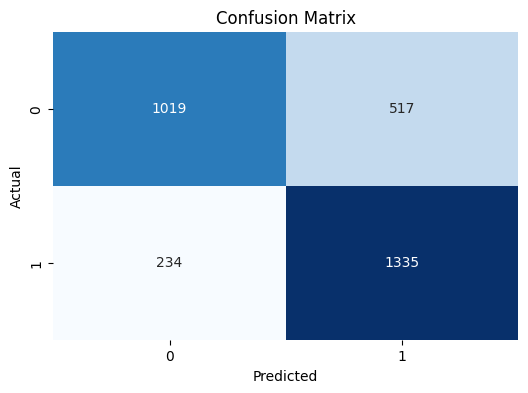

In [19]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

y_pred_knn = knn.predict(X_test)
acc_knn = accuracy_score(y_test, y_pred_knn)
clf_report = classification_report(y_test, y_pred_knn)

print(f"Accuracy Score of KNN is : {acc_knn}")
print(f"Classification Report : \n{clf_report}")

# Convert the code below into function to display confusion matrix
confusion = confusion_matrix(y_test, y_pred_knn)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [20]:
from sklearn.svm import SVC

svm = SVC(kernel='linear') 
svm.fit(X_train,y_train)

preds = svm.predict(X_test)
print(accuracy_score(y_test, preds))
print(confusion_matrix(y_test,preds)) 

0.7616747181964574
[[1053  483]
 [ 257 1312]]


In [21]:
from sklearn.ensemble import GradientBoostingClassifier

gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

y_pred_gb = gb.predict(X_test)

acc_gb = accuracy_score(y_test, y_pred_gb)
conf = confusion_matrix(y_test, y_pred_gb)
clf_report = classification_report(y_test, y_pred_gb)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_gb}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.77487922705314
Confusion Matrix : 
[[1105  431]
 [ 268 1301]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.80      0.72      0.76      1536
           1       0.75      0.83      0.79      1569

    accuracy                           0.77      3105
   macro avg       0.78      0.77      0.77      3105
weighted avg       0.78      0.77      0.77      3105



In [22]:
from sklearn.ensemble import AdaBoostClassifier

ada = AdaBoostClassifier()
ada.fit(X_train,y_train)

preds = ada.predict(X_test)
print(accuracy_score(y_test, preds))

0.7661835748792271


In [23]:
from xgboost import XGBClassifier

xgb = XGBClassifier()
xgb.fit(X_train, y_train)

preds = xgb.predict(X_test)
print(accuracy_score(y_test, preds))

0.8357487922705314


Accuracy: 0.81643
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1536
           1       0.79      0.86      0.83      1569

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105



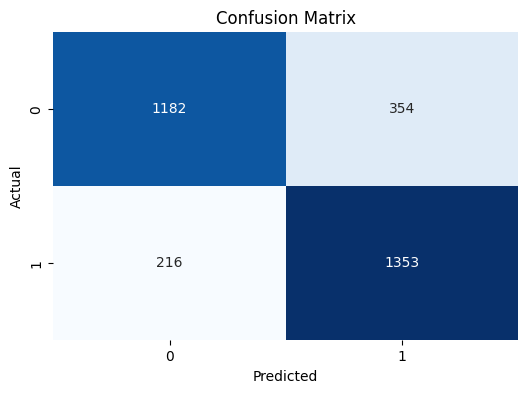

In [24]:
from lightgbm import LGBMClassifier 
from sklearn.metrics import classification_report

lgbm = LGBMClassifier()
lgbm.fit(X_train, y_train, verbose=0)

preds = lgbm.predict(X_test)
accuracy = accuracy_score(y_test, preds)
print(f"Accuracy: {accuracy:.5f}")

# Classification Report
class_report = classification_report(y_test, preds)
print(class_report)

# Confusion Matrix
confusion = confusion_matrix(y_test, preds)
plt.figure(figsize=(6, 4))
sns.heatmap(
    confusion, annot=True, fmt="d", cmap="Blues", cbar=False, 
    xticklabels=np.unique(y_train), yticklabels=np.unique(y_train)
)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [25]:
from catboost import CatBoostClassifier
from IPython.display import clear_output

cat = CatBoostClassifier(iterations=100, verbose=0)
cat.fit(X_train, y_train)

y_pred_cat = cat.predict(X_test)

acc_cat = accuracy_score(y_test, y_pred_cat)
conf = confusion_matrix(y_test, y_pred_cat)
clf_report = classification_report(y_test, y_pred_cat)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_cat}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8122383252818035
Confusion Matrix : 
[[1160  376]
 [ 207 1362]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.76      0.80      1536
           1       0.78      0.87      0.82      1569

    accuracy                           0.81      3105
   macro avg       0.82      0.81      0.81      3105
weighted avg       0.82      0.81      0.81      3105



In [26]:
from sklearn.ensemble import ExtraTreesClassifier

etc = ExtraTreesClassifier()
etc.fit(X_train, y_train)

y_pred_etc = etc.predict(X_test)

acc_etc = accuracy_score(y_test, y_pred_etc)
conf = confusion_matrix(y_test, y_pred_etc)
clf_report = classification_report(y_test, y_pred_etc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_etc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8892109500805153
Confusion Matrix : 
[[1309  227]
 [ 117 1452]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.92      0.85      0.88      1536
           1       0.86      0.93      0.89      1569

    accuracy                           0.89      3105
   macro avg       0.89      0.89      0.89      3105
weighted avg       0.89      0.89      0.89      3105



In [27]:
from sklearn.ensemble import VotingClassifier

classifiers = [
    ('Gradient Boosting Classifier', gb), 
    ('Cat Boost Classifier', cat), 
    ('XGboost', xgb),  
    ('Decision Tree', dtc),
    ('Extra Tree', etc), 
    ('Light Gradient', lgbm), 
    ('Random Forest', rd_clf), 
    ('Ada Boost', ada), 
    ('Logistic', lr),
    ('Knn', knn)
]
vc = VotingClassifier(estimators = classifiers)
vc.fit(X_train, y_train)

y_pred_vc = vc.predict(X_test)

acc_vtc = accuracy_score(y_test, y_pred_vc)
conf = confusion_matrix(y_test, y_pred_vc)
clf_report = classification_report(y_test, y_pred_vc)

print(f"Accuracy Score of Ada Boost Classifier is : {acc_vtc}")
print(f"Confusion Matrix : \n{conf}")
print(f"Classification Report : \n{clf_report}")

Accuracy Score of Ada Boost Classifier is : 0.8183574879227054
Confusion Matrix : 
[[1177  359]
 [ 205 1364]]
Classification Report : 
              precision    recall  f1-score   support

           0       0.85      0.77      0.81      1536
           1       0.79      0.87      0.83      1569

    accuracy                           0.82      3105
   macro avg       0.82      0.82      0.82      3105
weighted avg       0.82      0.82      0.82      3105

